## **Exploratory Data Analysis, Data Preparation, Data Cleaning**

### Exploratory Data Analysis - Preliminary Data Checks
Run firstly after each kernel session

Check if the dataset has been correctly impoted and parsed out correctly

In [6]:
df_nyc.head(3)

id                                 name  host_id  host_name  \
0  2539   Clean & quiet apt home by the park     2787       John   
1  2595                Skylit Midtown Castle     2845   Jennifer   
2  3647  THE VILLAGE OF HARLEM....NEW YORK !     4632  Elisabeth   

  neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0            Brooklyn    Kensington  40.64749  -73.97237     Private room   
1           Manhattan       Midtown  40.75362  -73.98377  Entire home/apt   
2           Manhattan        Harlem  40.80902  -73.94190     Private room   

   price  minimum_nights  number_of_reviews last_review  reviews_per_month  \
0    149               1                  9  2018-10-19               0.21   
1    225               1                 45  2019-05-21               0.38   
2    150               3                  0         NaN                NaN   

   calculated_host_listings_count  availability_365  
0                               6               365  
1                               2               355  
2                               1               365

Check datatypes of each variables

In [7]:
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

Check all numerical variables that could be the potential target and features, and their descriptive statistics.

In [8]:
df_nyc[['price','minimum_nights','number_of_reviews','availability_365','calculated_host_listings_count','reviews_per_month']].describe()

price  minimum_nights  number_of_reviews  availability_365  \
count  48895.000000    48895.000000       48895.000000      48895.000000   
mean     152.720687        7.029962          23.274466        112.781327   
std      240.154170       20.510550          44.550582        131.622289   
min        0.000000        1.000000           0.000000          0.000000   
25%       69.000000        1.000000           1.000000          0.000000   
50%      106.000000        3.000000           5.000000         45.000000   
75%      175.000000        5.000000          24.000000        227.000000   
max    10000.000000     1250.000000         629.000000        365.000000   

       calculated_host_listings_count  reviews_per_month  
count                    48895.000000       38843.000000  
mean                         7.143982           1.373221  
std                         32.952519           1.680442  
min                          1.000000           0.010000  
25%                          1.000000           0.190000  
50%                          1.000000           0.720000  
75%                          2.000000           2.020000  
max                        327.000000          58.500000

It is worth noting that the lowest value of price and availability_365 is at zeroes

Next, we're removing the zeroes (not missing values) for the price and availability_365 column. <br> We won't remove zeroes in the number_of_reviews column, since we think it would be possible for someone to leave no reviews. <br>
Additionally, for listings that has 0 in availability and also has 0 in number of review, we will be removing those because it means the listings might actually have never been available or have never been rented before.

In [9]:
price_zero = df_nyc[['price']]==0
price_zero.sum()

price    11
dtype: int64

In [10]:
df_nyc = df_nyc[~price_zero['price']]
price_zero_after = df_nyc[['price']]==0
price_zero_after.sum()

price    0
dtype: int64

In [11]:
filtered_df_availability_reviews = (df_nyc['availability_365'] == 0) & (df_nyc['number_of_reviews'] == 0)
filtered_df_availability_reviews.sum()

4844

Now, we are assuming that approx. 4000 listings posted are inactive, due to zero number of reviews made within a yearly periood. <br>

Next, we are removing those listings based on this criteria.

In [12]:
avail_zero = df_nyc[['availability_365']]==0
avail_zero.sum()

availability_365    17530
dtype: int64

In [13]:
df_nyc = df_nyc[~filtered_df_availability_reviews]
avail_zero_after = df_nyc[['availability_365']]==0
avail_zero_after.sum()

availability_365    12686
dtype: int64

After removal of some rows according to the criteria mentioned above, we are left with approx. 12,000 rows in the availability_365 column

### Exploratory Data Analysis - Utilisation of SQL

In [14]:
# IMPORTANT!!!! If it is necessary to RUN / RE-RUN this SQL, please start run from this cell to connect to database

conn = sqlite3.connect("AB_NYC_2019.db")
c = conn.cursor()

In [15]:
# Make sure it is empty in the database (no any table exists)

c.execute("Drop table AB_NYC_2019")
conn.commit()

In [16]:
# Create a table

c.execute("CREATE TABLE AB_NYC_2019(id INTEGER, name TEXT, host_id INTEGER, host_name TEXT, neighbourhood_group TEXT, neighbourhood TEXT, latitude NUMERIC, \
          longitude NUMERIC, room_type TEXT, price NUMERIC, minimum_nights NUMERIC, number_of_reviews INTEGER, last_review DATE, reviews_per_month NUMERIC, \
          calculated_host_listings_count NUMERIC, availability_365 NUMERIC)")
conn.commit()

In [17]:
# Import the csv file to the table

read_csv_db = "AB_NYC_2019.csv"

with open(read_csv_db, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    headers = next(reader)  # Need to skip the header row because the column names are on the first row of the CSV file
    for row in reader:
        c.execute("INSERT INTO AB_NYC_2019 (id, name, host_id, host_name, neighbourhood_group, neighbourhood, latitude, longitude, room_type, \
                  price, minimum_nights, number_of_reviews, last_review, reviews_per_month, calculated_host_listings_count, availability_365) \
                  VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", row)
# ChatGPT is used to help generate the above sophisticated codes for importing the CSV file to the database with skipping the header and inserting all the values to corresponding columns correctly.

c.execute("SELECT COUNT(*) FROM AB_NYC_2019")
print(f"Number of rows in the 'NYC Database' table: {c.fetchone()[0]}")
c.execute("PRAGMA table_info(AB_NYC_2019)")
columns = c.fetchall()
print(f"\nTotal number of columns in the table: {len(columns)}")
conn.commit()

Number of rows in the 'NYC Database' table: 48895

Total number of columns in the table: 16


In [18]:
# Delete the columns by dropping the original table and re-generating a new table

c.execute("CREATE TABLE IF NOT EXISTS NEW (host_id INTEGER, neighbourhood_group TEXT, neighbourhood TEXT, latitude NUMERIC, longitude NUMERIC, room_type TEXT, \
          price NUMERIC, minimum_nights NUMERIC, number_of_reviews INTEGER, reviews_per_month NUMERIC, calculated_host_listings_count NUMERIC, availability_365 NUMERIC)")

c.execute("INSERT INTO NEW ( host_id, neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, \
          reviews_per_month, calculated_host_listings_count, availability_365 ) SELECT host_id, neighbourhood_group, neighbourhood, latitude, longitude, \
          room_type, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, availability_365 FROM AB_NYC_2019")

c.execute("DROP TABLE AB_NYC_2019")
c.execute("ALTER TABLE NEW RENAME TO AB_NYC_2019")

c.execute("SELECT COUNT(*) FROM AB_NYC_2019")
print(f"Final number of rows in the 'NYC Database' table: {c.fetchone()[0]}")
conn.commit()

Final number of rows in the 'NYC Database' table: 48895


In [19]:
# Present the column names and data the table has
# since the result is too long, we decided to hide it

c.execute("PRAGMA table_info(AB_NYC_2019)")
columns = c.fetchall()
#print("Current columns the table has:")
#for col in columns:
    #print(col)

#print("")
#print(f"\nTotal number of columns in the table: {len(columns)}")

c.execute("Select * from AB_NYC_2019")
data = c.fetchall()
#def printAll(table):
    #for item in table:
        #print(item)
#print("\nPresent all data in new table after removing the unnecessary columns:")
#printAll(c.fetchall())

#conn.commit()

In [20]:
c.execute("SELECT neighbourhood_group, COUNT(*), ROUND(AVG(price), 2) FROM AB_NYC_2019 GROUP BY neighbourhood_group ORDER BY AVG(price)")
print(pd.DataFrame(c.fetchall(), columns=["Neighbourhood Group", "No. of Listings", "Average Price"]))

print("")

c.execute("SELECT room_type, COUNT(*), ROUND(AVG(price), 2) FROM AB_NYC_2019 GROUP BY room_type ORDER BY AVG(price)")
print(pd.DataFrame(c.fetchall(), columns=["Room Type", "No. of Listings", "Average Price"]))

conn.commit()

  Neighbourhood Group  No. of Listings  Average Price
0               Bronx             1091          87.50
1              Queens             5666          99.52
2       Staten Island              373         114.81
3            Brooklyn            20104         124.38
4           Manhattan            21661         196.88

         Room Type  No. of Listings  Average Price
0      Shared room             1160          70.13
1     Private room            22326          89.78
2  Entire home/apt            25409         211.79


Before going to detailed invertigation of the database "AB_NYC_2019", it is necessary to quote the count the number of listings per neighborhood group and per room type with the average price. From the results, it reveals that Manhattan has the highest average price (196.88) which means that the listings in that place are usually the most expensive. It also has the highest number of listings (21661) which suggesting high demand. Manhattan Drives the Market. Queens seems a balanced option for people in terms of huge number of listings (5666) and cheaper price (99.52). It shows that people might look for lower prices and a quieter stay compared to Brooklyn or Manhattan. It is interesting that the listings in Staten Island is the lowest but the price is relatively high compared to Bronx and Queens because this place is not close to the city center. It is obvious that there is only a small proportion of listing of shared rooms in overall, and the price of renting an entire home/apt is extremely higher compared to the rest of two types.

Below are the codes to find out the amximum and minimum prices for different room types in different neighbourhood groups, ordered by room type.

In [21]:
c.execute("SELECT neighbourhood_group, room_type, MAX(price), MIN(price), MAX(price) - MIN(price) AS price_range FROM AB_NYC_2019 GROUP BY room_type, neighbourhood_group ORDER BY neighbourhood_group")
print(pd.DataFrame(c.fetchall(), columns=["Neighbourhood Group", "Room Type", "Max. Price", "Min. Price", "Price Range"]))

conn.commit()

   Neighbourhood Group        Room Type  Max. Price  Min. Price  Price Range
0                Bronx  Entire home/apt        1000          28          972
1                Bronx     Private room        2500           0         2500
2                Bronx      Shared room         800          20          780
3             Brooklyn  Entire home/apt       10000           0        10000
4             Brooklyn     Private room        7500           0         7500
5             Brooklyn      Shared room         725           0          725
6            Manhattan  Entire home/apt       10000           0        10000
7            Manhattan     Private room        9999          10         9989
8            Manhattan      Shared room        1000          10          990
9               Queens  Entire home/apt        2600          10         2590
10              Queens     Private room       10000          10         9990
11              Queens      Shared room        1800          11         1789

In [22]:
c.execute("SELECT neighbourhood_group, room_type, COUNT(*), ROUND(AVG(price), 2) FROM AB_NYC_2019 GROUP BY room_type, neighbourhood_group ORDER BY AVG(price)")
print(pd.DataFrame(c.fetchall(), columns=["Neighbourhood Group", "Room Type", " No. of Listings", "Average Price"]))

conn.commit()

   Neighbourhood Group        Room Type   No. of Listings  Average Price
0             Brooklyn      Shared room               413          50.53
1        Staten Island      Shared room                 9          57.44
2                Bronx      Shared room                60          59.80
3        Staten Island     Private room               188          62.29
4                Bronx     Private room               652          66.79
5               Queens      Shared room               198          69.02
6               Queens     Private room              3372          71.76
7             Brooklyn     Private room             10132          76.50
8            Manhattan      Shared room               480          88.98
9            Manhattan     Private room              7982         116.78
10               Bronx  Entire home/apt               379         127.51
11              Queens  Entire home/apt              2096         147.05
12       Staten Island  Entire home/apt            

Right now, it has to be discovered the average price for different room types in different neighbourhood groups, ordered by average price, and check their number of listings. The table demonstrates that shared rooms consistently offer the cheapest accommodations but are less popular than private rooms or entire home/apt. Manhattan and Brooklyn have luxury pricings. Even the shared rooms in Manhatten they are more expensive than the private rooms and entire homes/apts in the rest of the 4 neighbourhood groups. Also, Bronx and Staten Island offer the most budget-friendly options, particularly for shared rooms and private rooms.

In [23]:
c.execute("SELECT neighbourhood, neighbourhood_group, room_type, ROUND(AVG(price), 2) FROM AB_NYC_2019 GROUP BY neighbourhood ORDER BY AVG(price) DESC LIMIT 10")
print(pd.DataFrame(c.fetchall(), columns=["Neighbourhood", "Neighbourhood Group", "Room Type", "Average Price"]))

conn.commit()

       Neighbourhood Neighbourhood Group        Room Type  Average Price
0     Fort Wadsworth       Staten Island  Entire home/apt         800.00
1            Woodrow       Staten Island  Entire home/apt         700.00
2            Tribeca           Manhattan     Private room         490.64
3           Sea Gate            Brooklyn  Entire home/apt         487.86
4          Riverdale               Bronx  Entire home/apt         442.09
5       Prince's Bay       Staten Island  Entire home/apt         409.50
6  Battery Park City           Manhattan     Private room         367.56
7  Flatiron District           Manhattan  Entire home/apt         341.93
8      Randall Manor       Staten Island     Private room         336.00
9               NoHo           Manhattan     Private room         295.72


The table retreived above is to find out the top 10 neighbourhoods with the highest average price, and investigate which room type actually they belong to. From the results, the neighbourhood group "Staten Island" appears multiple times. It is surprised that the entire home/apt from Manhattan is not the top one. Staten Island neighborhoods (e.g., Fort Wadsworth, Woodrow, Prince's Bay, Randall Manor) show relatively high average prices for "Entire home/apt" and "Private room" listings.

In [24]:
c.execute("SELECT neighbourhood_group, room_type, ROUND((CAST(COUNT(*) AS FLOAT) / (SUM(COUNT(*)) OVER (PARTITION BY neighbourhood_group)) * 100), 2) AS percentage_n_group, \
          COUNT(*) FROM AB_NYC_2019 GROUP BY room_type, neighbourhood_group ORDER BY neighbourhood_group")
print(pd.DataFrame(c.fetchall(), columns=["Neighbourhood Group", "Room Type", "% of Listings", "No. of Listings"]))

conn.commit()

   Neighbourhood Group        Room Type  % of Listings  No. of Listings
0                Bronx  Entire home/apt          34.74              379
1                Bronx     Private room          59.76              652
2                Bronx      Shared room           5.50               60
3             Brooklyn  Entire home/apt          47.55             9559
4             Brooklyn     Private room          50.40            10132
5             Brooklyn      Shared room           2.05              413
6            Manhattan  Entire home/apt          60.93            13199
7            Manhattan     Private room          36.85             7982
8            Manhattan      Shared room           2.22              480
9               Queens  Entire home/apt          36.99             2096
10              Queens     Private room          59.51             3372
11              Queens      Shared room           3.49              198
12       Staten Island  Entire home/apt          47.18          

Now, let's check out the percentage of listings above within the neighborhood groups for each room type, ordered by the places, and check their number of listings for the room type of each neighbourhood group. Usually the room type "Private room" is the most common listings compared to the rest of 2 types, but Staten Island has a surprising balance between "Private Room" and "Entire homes/apt". In contrast, listing "Entire home/apt" is the most common in Manhattan. The proportion of "Shared Room" is consistently below 5% at all. It might imply that it is less common option for people provided by the hosts.

In [25]:
c.execute("SELECT room_type, neighbourhood_group, ROUND((CAST(COUNT(*) AS FLOAT) / (SUM(COUNT(*)) OVER (PARTITION BY room_type)) * 100), 2), \
          COUNT(*) FROM AB_NYC_2019 GROUP BY room_type, neighbourhood_group ORDER BY room_type")
print(pd.DataFrame(c.fetchall(), columns=["Room Type", "Neighbourhood Group", "% of Listings", "No. of Listings"]))

conn.commit()

          Room Type Neighbourhood Group  % of Listings  No. of Listings
0   Entire home/apt               Bronx           1.49              379
1   Entire home/apt            Brooklyn          37.62             9559
2   Entire home/apt           Manhattan          51.95            13199
3   Entire home/apt              Queens           8.25             2096
4   Entire home/apt       Staten Island           0.69              176
5      Private room               Bronx           2.92              652
6      Private room            Brooklyn          45.38            10132
7      Private room           Manhattan          35.75             7982
8      Private room              Queens          15.10             3372
9      Private room       Staten Island           0.84              188
10      Shared room               Bronx           5.17               60
11      Shared room            Brooklyn          35.60              413
12      Shared room           Manhattan          41.38          

There are the percentages of listings for each room type group in overall, listed according to room type, and check their number of listings in the room type groups. Manhattan and Brooklyn dominate across all room types. They have the highest proportions for "Entire home/apt" and "Shared room", which might reveal that there is a high demand of people on living in these two areas or travelling to there so there is a high supply. On the other hand, Bronx and Staten Island have small distributions of for each room type across different neighbourhood groups, especially for Staten Island. It might prove that there are limited popularity for short-term rentals.

In [26]:
conn.close()

### Exploratory Data Analysis - Plots Visualisation

**Disclaimer on the usage of AI in the EDA part of our project** <br>
In the exploratory data analysis part of our project we mainly used the documentation of libraries such as seaborn to create the plots. <br> AI was used in this parts order to speed up the process of selecting cosmetic features of the plot e.g. the palette, legend or the rotation of certain plots.

Firstly, we want to visualise how many listings that are available in each neighbourhood group. By looking at the pie chart presented below we can clearly see that around 85% of all listings are in Brooklyn and Manhattan, meanwhile listings in Bronx and Staten Island amass to only 3% of all listings.

In [27]:
neighbourhood_groups = df_nyc['neighbourhood_group'].unique()
neighbourhood_groups
neighbourhood_counts = df_nyc['neighbourhood'].value_counts()
neighbourhood_counts = neighbourhood_counts.head(15)
explode = [0.1,0.1,0,0,0]

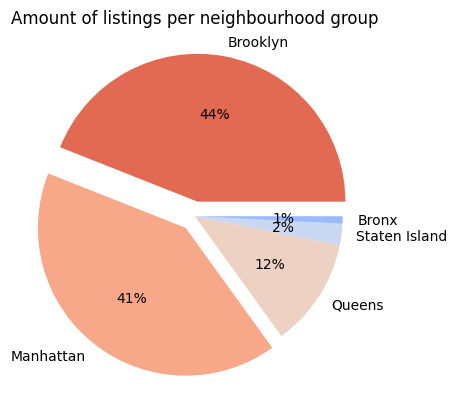

In [28]:
palette = sns.color_palette("coolwarm")
palette.reverse()
plt.pie(df_nyc['neighbourhood_group'].value_counts(), labels=neighbourhood_groups, colors=palette, explode=explode, autopct='%.0f%%')
plt.title('Amount of listings per neighbourhood group')
plt.show()

Now let us get more speccific and analyse the neighbourhoods. There are a lot of neighbourhoods in New York so we decided to only focus on the 15 neighbourhoods that have the most observations. To do that we count

In [29]:
neighbourhood_counts = df_nyc['neighbourhood'].value_counts()
neighbourhood_counts = neighbourhood_counts.head(15)

Text(0.5, 1.0, 'Top 10 Neighbourhoods')

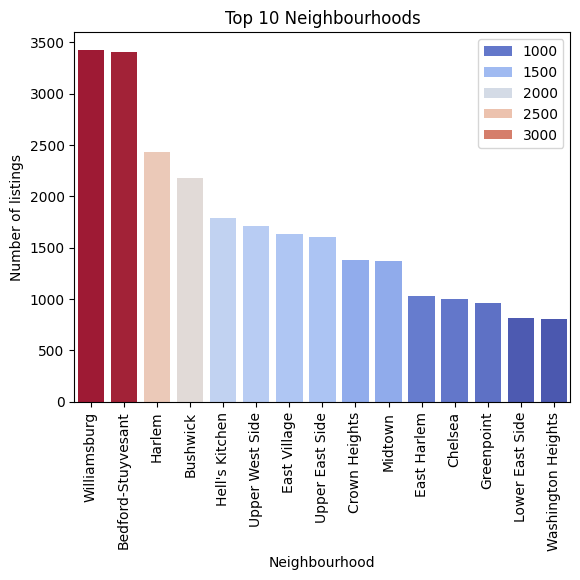

In [30]:
n_plot =sns.barplot(x=neighbourhood_counts.index, y=neighbourhood_counts.values, hue = neighbourhood_counts.values, palette = 'coolwarm', estimator="sum")

plt.xticks(rotation=90)
plt.xlabel('Neighbourhood')
plt.ylabel('Number of listings')
plt.title('Top 10 Neighbourhoods')

Among these listing based on the neighbourhood, Williamsburg and Bedford-Stuyvesant have clearle the most listing on air BnB with both of them having around 3300 if them while the next neighbourhood with the largest amount of listings has 2400 of them

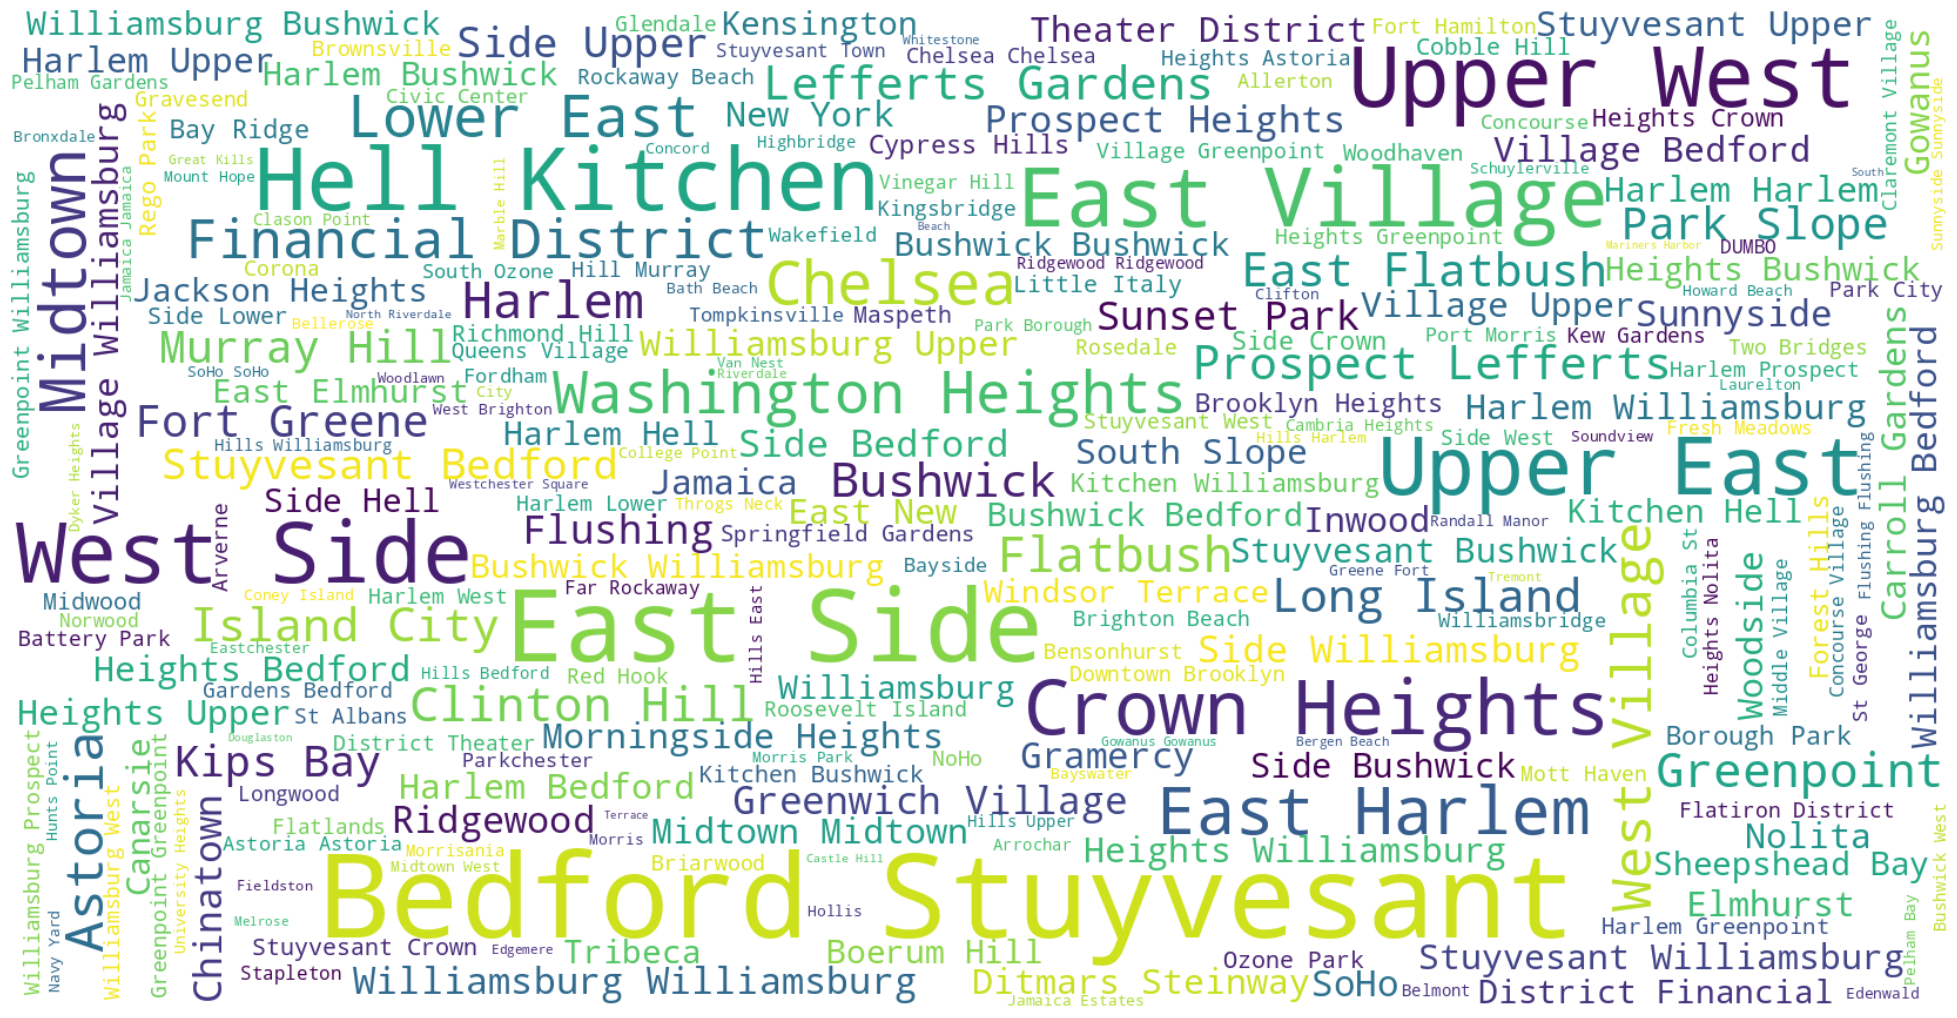

In [31]:
plt.subplots(figsize=(25,15))
wordcloud = WordCloud(
                          background_color='white',
                          max_words=250,
                          max_font_size=100,
                          width=1650,
                          height=850
                         ).generate(" ".join(df_nyc['neighbourhood']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


While this word cloud might not have the most meaningful impact on our EDA it still allows us to get a rough idead about which neighbourhoods contain a lot of listings and which are significantly less popular. Interestingly enough some popular neighbourhoods like SoHo or NoHo have very few listings in comparison to others. That could however be related to their smaller size.

In [32]:
df_nyc['room_type'].value_counts()

room_type
Entire home/apt    23155
Private room       19842
Shared room         1043
Name: count, dtype: int64

It is important to do even the most simple analysis in terms of room type distribution because there is an obvious disprepancy in between shared rooms and other types of rooms. Most probably it is due to the nature of Airbnb as a platform. Most private host will have eaither a flat, a house or an apartment, hence the low amount of shared rooms available on this platform. It is also something that should be taken into consideration in the latter parts of our project.

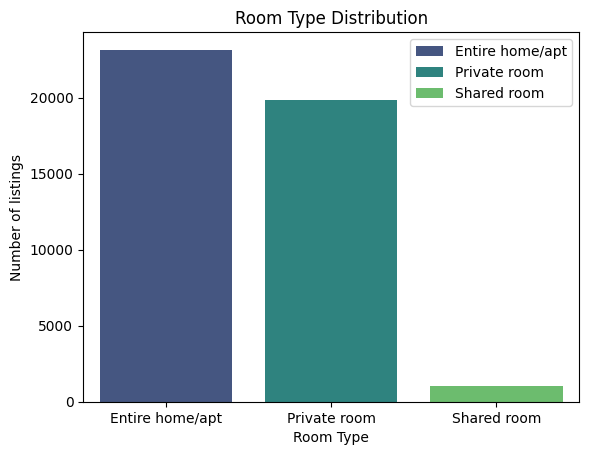

In [33]:
sns.barplot(x=df_nyc['room_type'].value_counts().index, y=df_nyc['room_type'].value_counts().values, palette='viridis', hue=df_nyc['room_type'].value_counts().index, legend = True)
plt.xlabel('Room Type')
plt.ylabel('Number of listings')
plt.title('Room Type Distribution')
plt.legend(fontsize=10)
plt.show()

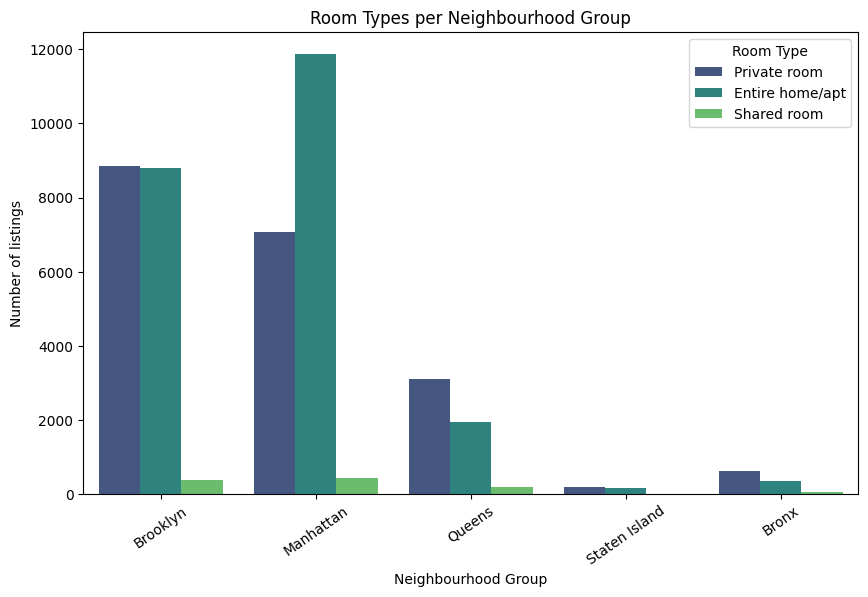

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_nyc, x='neighbourhood_group', hue='room_type', palette='viridis')
plt.title('Room Types per Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Number of listings')
plt.xticks(rotation=35)
plt.legend(title='Room Type')
plt.show()

Based on the plot, we can observe that each neighbourhood group follows a similar pattern. Private rooms are a popular choice across most areas. Manhattan, in particular, stands out as an affluent area and a major business hub, well-known for its numerous tourist attractions. From a market perspective, it makes sense to rent out entire apartments in Manhattan due to its convenience and the likelihood that wealthier tenants will prefer the privacy and exclusivity of renting an entire unit.

We want to aggregrate the prices according to each room type in their average (mean) and median prices

In [35]:
entire_home_prices = df_nyc.loc[df_nyc['room_type'] == 'Entire home/apt', 'price']
private_room_prices = df_nyc.loc[df_nyc['room_type'] == 'Private room', 'price']
shared_room_prices = df_nyc.loc[df_nyc['room_type'] == 'Shared room', 'price']
entire_home_prices_mean = entire_home_prices.mean()
private_room_prices_mean = private_room_prices.mean()
shared_room_prices_mean = shared_room_prices.mean()
entire_home_prices_mean, private_room_prices_mean, shared_room_prices_mean

(209.50416756640035, 89.19766152605584, 66.25790987535954)

In [36]:
entireRoomPrices = df_nyc.loc[df_nyc['room_type'] == 'Entire home/apt', 'price']
privateRoomPrices = df_nyc.loc[df_nyc['room_type'] == 'Private room', 'price']
sharedRoomPrices = df_nyc.loc[df_nyc['room_type'] == 'Shared room', 'price']
entireRoomPrices_median = entireRoomPrices.median()
privateRoomPrices_median = privateRoomPrices.median()
sharedRoomPrices_median = sharedRoomPrices.median()
entireRoomPrices_median, privateRoomPrices_median, sharedRoomPrices_median

(160.0, 70.0, 45.0)

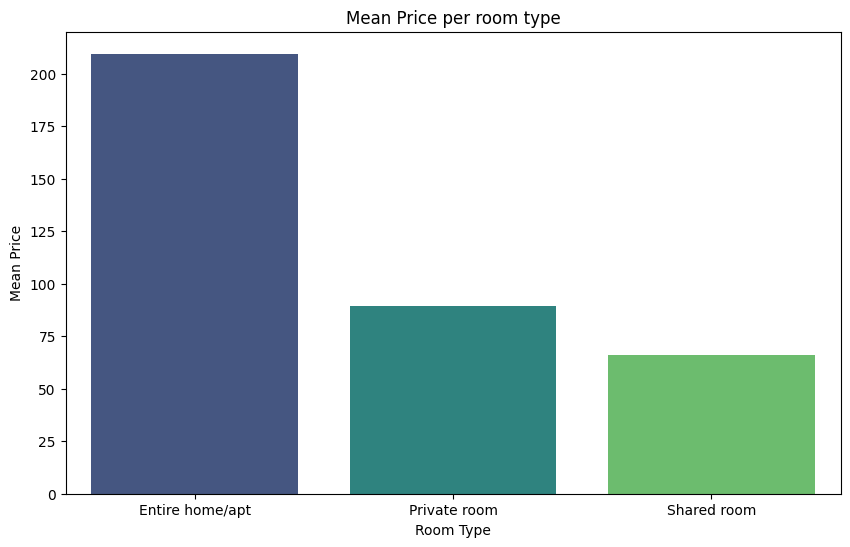

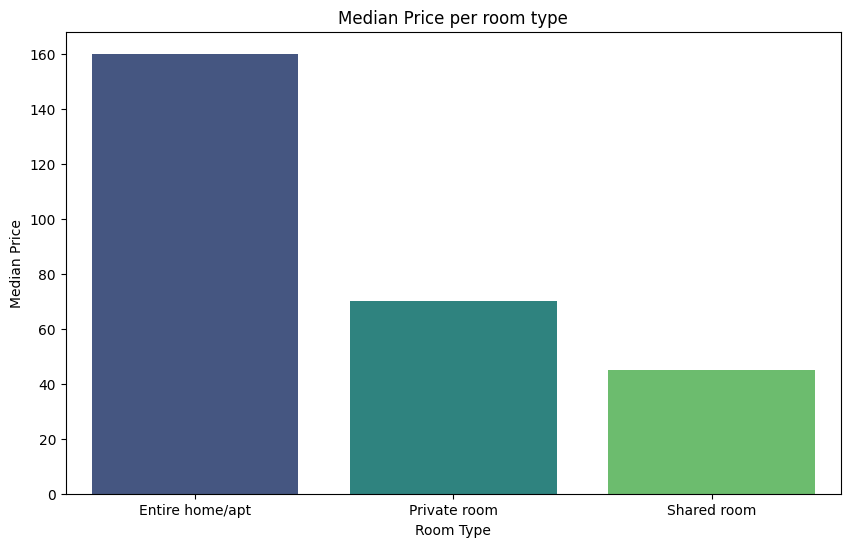

In [37]:
room_type_prices = {
    'Entire home/apt': entire_home_prices_mean,
    'Private room': private_room_prices_mean,
    'Shared room': shared_room_prices_mean
}

room_types = list(room_type_prices.keys())
mean_prices = list(room_type_prices.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=room_types, y=mean_prices, palette='viridis', hue = room_types)
plt.title('Mean Price per room type')
plt.xlabel('Room Type')
plt.ylabel('Mean Price')
plt.show()

room_type_prices = {
    'Entire home/apt': entireRoomPrices_median,
    'Private room': privateRoomPrices_median,
    'Shared room': sharedRoomPrices_median
}

room_types = list(room_type_prices.keys())
median_prices = list(room_type_prices.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=room_types, y=median_prices, palette='viridis', hue = room_types)
plt.title('Median Price per room type')
plt.xlabel('Room Type')
plt.ylabel('Median Price')
plt.show()

While at first glance the trends of prices presented on the barplot above are similar to what we would expect, there are some things that are worth mentioning and somewhat surprising. Mean price of Entire homes/apartments is very high. As we mentioned above, a lot of such listing are located in Manhattan which is an extremely popular location for tourists as well as a business hub, therefore we can expect some of the most expensive listings to appear there.

Now when we compere the average price of private rooms in comparison to shared rooms we can notice something interesting. The price difference between them is probalby smaller then one would expect coming at only around 20 dollars per average. While the difference is still visible, it is not too significant considering that one would get a private room instead of one that is shared with other people

We can observe similar trends on the plot displaying the median values. The only change worth noticing is the fact that the median of entire homes and apartments is visibly lower. That might suggest that the dataset is right-skewed and there are some listings with very high prices. It also makes sense for those listings to be entire homes and not other room types.

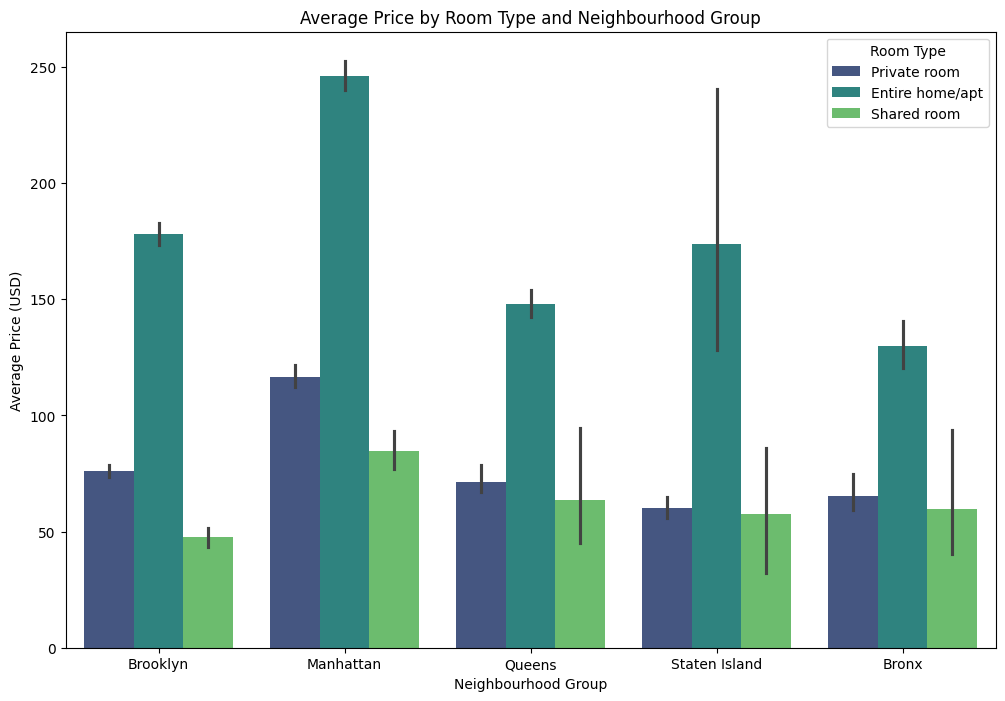

In [38]:
plt.figure(figsize=(12, 8))
sns.barplot(x='neighbourhood_group', y='price', hue='room_type', data=df_nyc, palette='viridis')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Price (USD)')
plt.title('Average Price by Room Type and Neighbourhood Group')
plt.legend(title='Room Type')
plt.show()

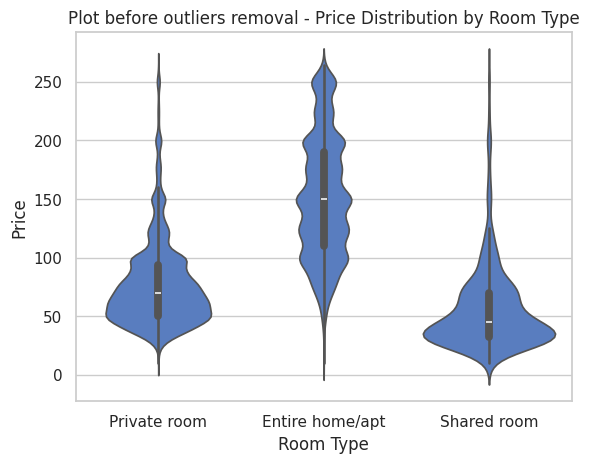

In [39]:
price_threshold = df_nyc['price'].quantile(0.9)
# I removed the prices that were in top 3 percentiles since there were skeewing the result
df_filtered = df_nyc[df_nyc['price'] < price_threshold]
sns.set_theme(style="whitegrid", palette="muted")
sns.violinplot(x='room_type', y='price', data=df_filtered)
plt.title('Plot before outliers removal - Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()

In order for the violin plot to be visible we decided to omitt the extremely expensive listings since they were skewing the result. This operation was only performed locally to present the plot.

The price distribution looks about as we would expect it to look. Majority of shared rooms are cheap, with few of them exceeding the price of 100. For entire homes and apartments there are very few listings cheaper than 50 and majority of listings are in the 100-200 price bracket. This is also the only room type that has a significant ammount of listings that have prices bigger than 200.
Lastly when we look at private rooms we can see that they fall in the middle with majority of listings costing between 50 and 100.

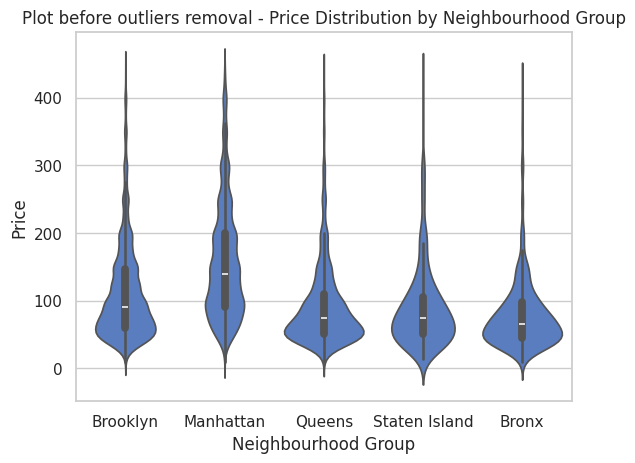

In [40]:
# Remove the top 3% of prices to reduce skewness
price_threshold = df_nyc['price'].quantile(0.97)
df_filtered = df_nyc[df_nyc['price'] < price_threshold]

# Create a violin plot for price and neighbourhood_group
sns.set_theme(style="whitegrid", palette="muted")
sns.violinplot(x='neighbourhood_group', y='price', data=df_filtered)
plt.title('Plot before outliers removal - Price Distribution by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Price')
plt.show()

The average price for Brooklyn, Queens, Staten Island, and the Bronx are relatively similar, while Manhattan has a slightly higher average. Again this fenomenon is likely observed due to Manhattan's higher demand, prime location, and greater concentration of luxury properties.

In [41]:
entire_home_reviews = df_nyc.loc[df_nyc['room_type'] == 'Entire home/apt', 'number_of_reviews']
private_room_reviews = df_nyc.loc[df_nyc['room_type'] == 'Private room', 'number_of_reviews']
shared_room_reviews = df_nyc.loc[df_nyc['room_type'] == 'Shared room', 'number_of_reviews']
entire_home_reviews_mean = entire_home_reviews.mean()
private_room_reviews_mean = private_room_reviews.mean()
shared_room_reviews_mean = shared_room_reviews.mean()
entire_home_reviews_mean, private_room_reviews_mean, shared_room_reviews_mean

(25.065860505290434, 27.113143836306826, 18.45541706615532)

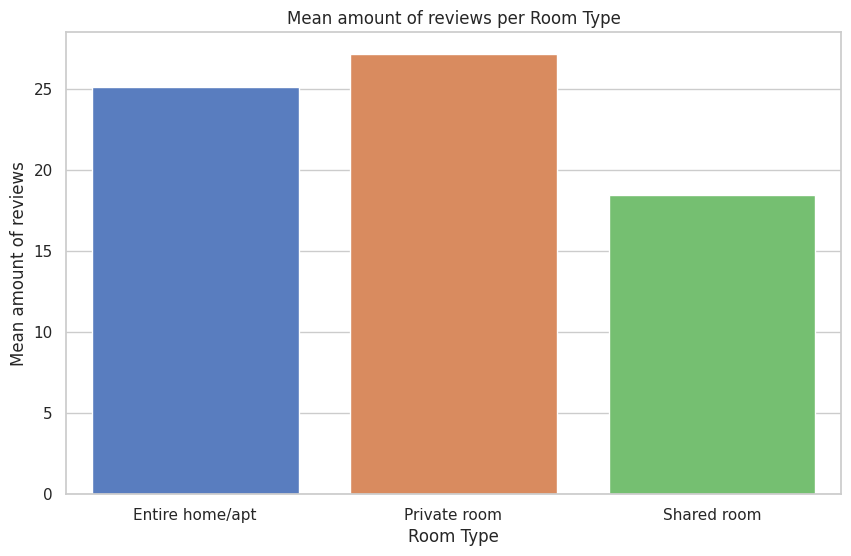

In [42]:
room_type_reviews = {
    'Entire home/apt': entire_home_reviews_mean,
    'Private room': private_room_reviews_mean,
    'Shared room': shared_room_reviews_mean
}

room_types = list(room_type_reviews.keys())
mean_reviews = list(room_type_reviews.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=room_types, y=mean_reviews, palette='muted', hue=room_types)
plt.title('Mean amount of reviews per Room Type')
plt.xlabel('Room Type')
plt.ylabel('Mean amount of reviews')
plt.show()

The graph illustrates the average number of reviews received per room type, with private rooms garnering the highest number of reviews, while shared rooms receive the fewest.

In [43]:
df_nyc_2 = df_nyc.copy()
df_nyc_2 = df_nyc_2[df_nyc_2['price']>2000]
df_nyc_2

id                                           name    host_id  \
946      363673               Beautiful 3 bedroom in Manhattan     256239   
1862     826690               Sunny, Family-Friendly 2 Bedroom    4289240   
2018     893413     Architecturally Stunning Former Synagogue!    4751930   
2698    1448703            Beautiful 1 Bedroom in Nolita/Soho      213266   
3537    2110145             UWS 1BR w/backyard + block from CP    2151325   
...         ...                                            ...        ...   
45867  34981637    bay ridge & sunset park furnished apartment  263564234   
46533  35297214                      Amazing Chelsea 4BR Loft!  256649546   
46614  35345358                 Northside Williamsburg Stunner     956324   
48043  36056808   Luxury TriBeCa Apartment at an amazing price  271248669   
48304  36189195  Next to Times Square/Javits/MSG! Amazing 1BR!  270214015   

         host_name neighbourhood_group     neighbourhood  latitude  longitude  \
946         Tracey           Manhattan   Upper West Side  40.80142  -73.96931   
1862          Lucy            Brooklyn  Prospect Heights  40.67919  -73.97191   
2018        Martin           Manhattan      East Village  40.72668  -73.98179   
2698       Jessica           Manhattan            Nolita  40.72193  -73.99379   
3537   Jay And Liz           Manhattan   Upper West Side  40.77782  -73.97848   
...            ...                 ...               ...       ...        ...   
45867         Nony            Brooklyn         Bay Ridge  40.63087  -74.02006   
46533     Viberlyn           Manhattan           Chelsea  40.73999  -73.99806   
46614         Alex            Brooklyn      Williamsburg  40.71705  -73.96470   
48043        Jenny           Manhattan           Tribeca  40.71206  -74.00999   
48304      Rogelio           Manhattan    Hell's Kitchen  40.75533  -73.99866   

             room_type  price  minimum_nights  number_of_reviews last_review  \
946       Private room   3000               7                  0         NaN   
1862   Entire home/apt   4000               4                  0         NaN   
2018   Entire home/apt   2500              30                 15  2019-07-01   
2698   Entire home/apt   5000               1                  2  2013-09-28   
3537   Entire home/apt   6000              14                 17  2015-02-17   
...                ...    ...             ...                ...         ...   
45867  Entire home/apt   4200              60                  0         NaN   
46533  Entire home/apt   2995              30                  1  2019-06-24   
46614  Entire home/apt   4500              30                  0         NaN   
48043  Entire home/apt   6500             180                  0         NaN   
48304  Entire home/apt   2999              30                  0         NaN   

       reviews_per_month  calculated_host_listings_count  availability_365  
946                  NaN                               1               365  
1862                 NaN                               1                83  
2018                0.26                               1                89  
2698                0.03                               1               365  
3537                0.27                               1               359  
...                  ...                             ...               ...  
45867                NaN                               1                90  
46533               1.00                               1               214  
46614                NaN                               1               365  
48043                NaN                               1               365  
48304                NaN                               1               222  

[76 rows x 16 columns]

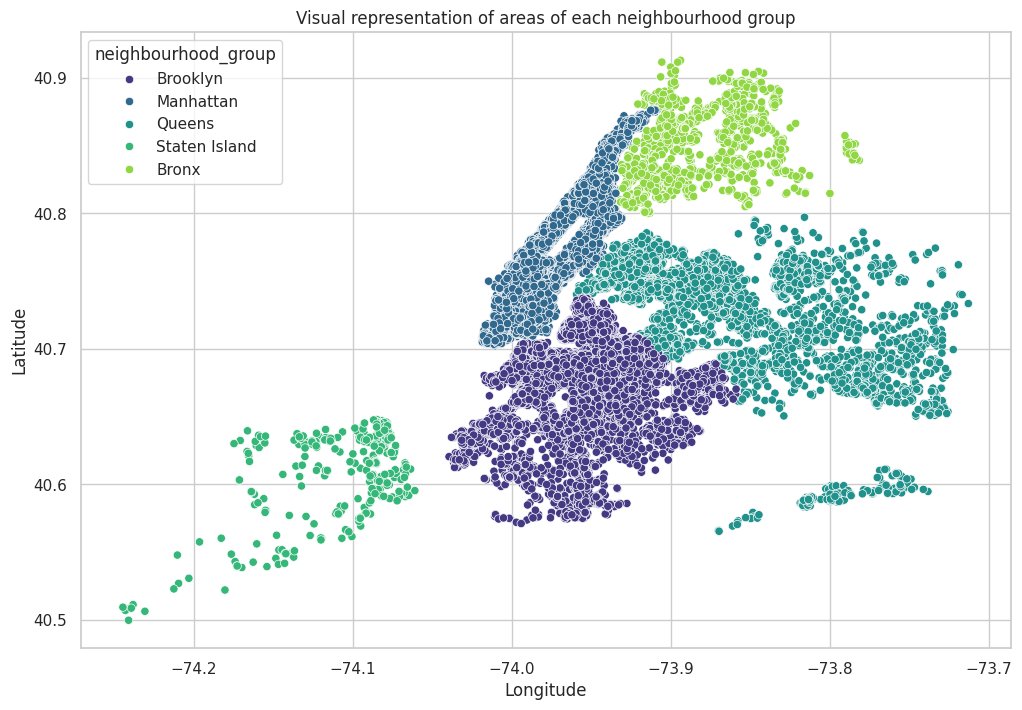

In [44]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_nyc, x="longitude", y="latitude", hue="neighbourhood_group",palette='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visual representation of areas of each neighbourhood group')
plt.show()

By displaying the listings in each neighbourhood we can also make some interesting observations:


*   The geographical center of the city consists of Manhattan, Brooklyn and the westernmost part of Queens
*   Staten Island is geographically far away from the rest of neighbourhoods and that is reflected by both ammount of listings and the price of them



In [108]:
geodf = gpd.GeoDataFrame(
    df_nyc_2,geometry=gpd.points_from_xy(df_nyc_2["longitude"],df_nyc_2["latitude"]),crs="epsg:4386")

map = geodf.explore(width=1200,height=700)
map.save('airbnb_nyc_interactive_map.html')

from google.colab import files
files.download('airbnb_nyc_interactive_map.html')
#this interactive plot can be found via README or (https://dpchi12.github.io/Customer_Segment_NYC_Airbnb_python/airbnb_nyc_interactive_map.html)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The map above displays all the listing with prices above 2000. By looking at the map we can further support our hypothesis that majority of the most expensive listings are in manhattan. There are also quite a few of those in Brookly but nevertheless it is obvious which area has the most prestigeous apartments.

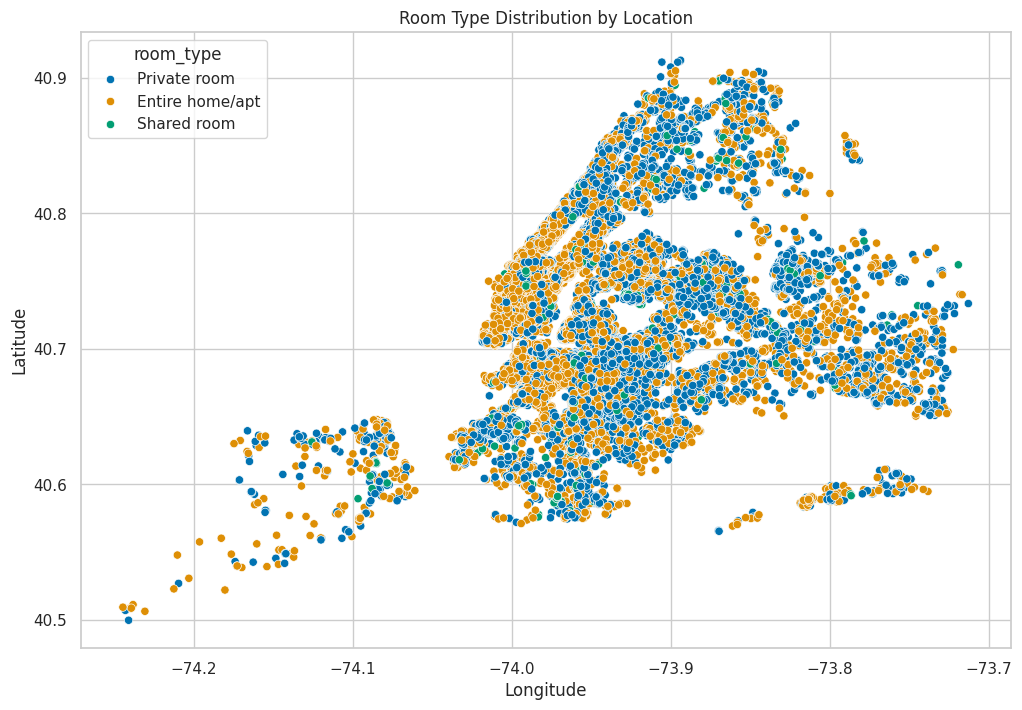

In [48]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_nyc, x="longitude", y="latitude", hue="room_type",palette="colorblind")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Room Type Distribution by Location')
plt.show()

By looking at the distributions of room types across New York we can clearly see that private rooms and entire apartments are by far the most popular type of listings and they appear accross all the neighbourhood groups. Interestingly enough we can notice that southern and central parts of manhattan almost fully consist of listings of type "entire house/apt". Again, this could be due to the touristic nature of this area.

Similar trends can be observed by looking at the average price of each room type per neighbourhood group. We can confidently say that the most expensive neighbourhood is Manhattan since every single room type has the highest average value out of every neighbourhood. Meanwhile Queens and Bronx are on the other side of spectrum with average prices being the lowest out of all neighbourgoods

### Check, remove, and treatment of missing values
Run firstly after each kernel session

Checking missing values

In [49]:
df_nyc.isnull().sum()

id                                   0
name                                 8
host_id                              0
host_name                           17
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       5207
reviews_per_month                 5207
calculated_host_listings_count       0
availability_365                     0
dtype: int64

Checking, should any duplicate data occurs. Meaning that there's wrong inputation or double-entry

In [50]:
duplicates = df_nyc.duplicated()
print(duplicates.sum())

duplicate_rows = df_nyc[duplicates]
print(duplicate_rows)

0
Empty DataFrame
Columns: [id, name, host_id, host_name, neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, last_review, reviews_per_month, calculated_host_listings_count, availability_365]
Index: []


Check rows that corresponds with review (last_review) and (reviews_per_month)

In [51]:
df_nyc[["last_review", "reviews_per_month"]]

last_review  reviews_per_month
0      2018-10-19               0.21
1      2019-05-21               0.38
2             NaN                NaN
3      2019-07-05               4.64
4      2018-11-19               0.10
...           ...                ...
48890         NaN                NaN
48891         NaN                NaN
48892         NaN                NaN
48893         NaN                NaN
48894         NaN                NaN

[44040 rows x 2 columns]

Removing last_review column since it only tells us the last reviewed date, this data will not provide meaningful insight

In [52]:
df_nyc.drop(['last_review'], axis = 1, inplace=True)

In [53]:
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44040 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              44040 non-null  int64  
 1   name                            44032 non-null  object 
 2   host_id                         44040 non-null  int64  
 3   host_name                       44023 non-null  object 
 4   neighbourhood_group             44040 non-null  object 
 5   neighbourhood                   44040 non-null  object 
 6   latitude                        44040 non-null  float64
 7   longitude                       44040 non-null  float64
 8   room_type                       44040 non-null  object 
 9   price                           44040 non-null  int64  
 10  minimum_nights                  44040 non-null  int64  
 11  number_of_reviews               44040 non-null  int64  
 12  reviews_per_month               38833

**Backing up our data for modelling purpose**

In [54]:
# To retain the original dataset, we will create a copy version and name it as backup
# Also, df_nyc is used for EDA Visualisation purpose
df_nyc_backup = df_nyc.copy()

In [55]:
# Drop unecessary varibles
df_nyc_backup.drop(['name','id','host_id','host_name','neighbourhood','latitude','longitude','reviews_per_month'], axis=1, inplace=True)

These name values will not be used further in the machine learning process, hence, we remove them.
Reviews per month will also get removed because we have information about the total number of reviews, and these 2 data are highly correlated. So we decided to remove reviews per month.


Final check before encoding and normalisation

In [56]:
df_nyc_backup.isnull().sum()
#there is no missing value

neighbourhood_group               0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

### One hot encoding, Normalisation, and Outliers Removal

In [57]:
df_nyc_backup.head(3)

neighbourhood_group        room_type  price  minimum_nights  \
0            Brooklyn     Private room    149               1   
1           Manhattan  Entire home/apt    225               1   
2           Manhattan     Private room    150               3   

   number_of_reviews  calculated_host_listings_count  availability_365  
0                  9                               6               365  
1                 45                               2               355  
2                  0                               1               365

We are making a copy of df_nyc_corr from df_nyc_backup for the correlation matrix purpose


In [58]:
df_nyc_corr = df_nyc_backup.copy()
df_nyc_corr.head(3)

neighbourhood_group        room_type  price  minimum_nights  \
0            Brooklyn     Private room    149               1   
1           Manhattan  Entire home/apt    225               1   
2           Manhattan     Private room    150               3   

   number_of_reviews  calculated_host_listings_count  availability_365  
0                  9                               6               365  
1                 45                               2               355  
2                  0                               1               365

#### Outliers Removal

We will choose 2 different methods to remove the outliers and compare their performance: Interquartile range (IQR) and Winsorisation to avoid inaccurate prediction.

In [59]:
# Remove outliers - IQR
Q1 = df_nyc_corr.groupby('room_type')['price'].transform('quantile', 0.25)
Q3 = df_nyc_corr.groupby('room_type')['price'].transform('quantile', 0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_nyc_IQR = df_nyc_corr[(df_nyc_corr['price'] >= lower_bound) & (df_nyc_corr['price'] <= upper_bound)]

In [60]:
# Winsorising to remove outliers
upper_bound_winsor = df_nyc_corr['price'].quantile(0.97)
df_nyc_winsor = df_nyc_corr.copy()
df_nyc_winsor['price'] = df_nyc_corr['price'].clip(lower=0, upper=upper_bound_winsor)

In [61]:
df_nyc_IQR.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41181 entries, 0 to 48894
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   neighbourhood_group             41181 non-null  object
 1   room_type                       41181 non-null  object
 2   price                           41181 non-null  int64 
 3   minimum_nights                  41181 non-null  int64 
 4   number_of_reviews               41181 non-null  int64 
 5   calculated_host_listings_count  41181 non-null  int64 
 6   availability_365                41181 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.5+ MB


In [62]:
df_nyc_winsor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44040 entries, 0 to 48894
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   neighbourhood_group             44040 non-null  object
 1   room_type                       44040 non-null  object
 2   price                           44040 non-null  int64 
 3   minimum_nights                  44040 non-null  int64 
 4   number_of_reviews               44040 non-null  int64 
 5   calculated_host_listings_count  44040 non-null  int64 
 6   availability_365                44040 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 3.7+ MB


#### Data Encoding and Data Normalisation - For Correlation Matrix Purposes

Categorical variables are encoded and normalised before creating correlation heatmap plots. <br>
We are applying this treatment to all of the datasets, which are:

*   Dataset with outliers –> df_nyc_corr
*   Dataset without outliers, IQR treatment –> df_nyc_IQR
*   Dataset without outliers, Winsorisation treatment –> df_nyc_winsor



In [63]:
# Data Encoding - ONLY FOR CORRELATION WITHOUT OUTLIERS PURPOSES
# DO NOT RUN TWICE
# RUN BEFORE CORRELATION
for cat in ['neighbourhood_group', 'room_type']:
    onehots = pd.get_dummies(df_nyc_corr[cat], prefix=cat).astype(int)
    df_nyc_corr = df_nyc_corr.join(onehots)
df_nyc_corr.drop(columns=['neighbourhood_group', 'room_type'], inplace=True)

# Data Normalisation - ONLY FOR CORRELATION WITHOUT OUTLIERS PURPOSES
# DO NOT RUN TWICE
# RUN BEFORE CORRELATION
numeric_columns = ['price', 'minimum_nights', 'number_of_reviews','availability_365','calculated_host_listings_count']
scaler = MinMaxScaler()
standard_scaler = StandardScaler()
df_nyc_corr[numeric_columns] = scaler.fit_transform(df_nyc_corr[numeric_columns])

In [64]:
df_nyc_corr.head(3)

price  minimum_nights  number_of_reviews  \
0  0.013914        0.000000           0.014308   
1  0.021522        0.000000           0.071542   
2  0.014014        0.001601           0.000000   

   calculated_host_listings_count  availability_365  \
0                        0.015337          1.000000   
1                        0.003067          0.972603   
2                        0.000000          1.000000   

   neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                          0                             1   
1                          0                             0   
2                          0                             0   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                              0                           0   
1                              1                           0   
2                              1                           0   

   neighbourhood_group_Staten Island  room_type_Entire home/apt  \
0                                  0                          0   
1                                  0                          1   
2                                  0                          0   

   room_type_Private room  room_type_Shared room  
0                       1                      0  
1                       0                      0  
2                       1                      0

Use one hot encoding to replace character value on neighbourhood_group and room_type, as numeric values will be needed for model training.

In [65]:
# Data Encoding - ONLY FOR CORRELATION WITH OUTLIERS (IQR) PURPOSES
# DO NOT RUN TWICE
# RUN BEFORE CORRELATION
for cat in ['neighbourhood_group', 'room_type']:
    onehots = pd.get_dummies(df_nyc_IQR[cat], prefix=cat).astype(int)
    df_nyc_IQR = df_nyc_IQR.join(onehots)
df_nyc_IQR.drop(columns=['neighbourhood_group', 'room_type'], inplace=True)

# Data Normalisation - ONLY FOR CORRELATION WITH OUTLIERS (IQR) PURPOSES
# DO NOT RUN TWICE
# RUN BEFORE CORRELATION
numeric_columns = ['price', 'minimum_nights', 'number_of_reviews','availability_365','calculated_host_listings_count']
scaler = MinMaxScaler()
standard_scaler = StandardScaler()
df_nyc_IQR[numeric_columns] = scaler.fit_transform(df_nyc_IQR[numeric_columns])

In [66]:
df_nyc_IQR.head(3)

price  minimum_nights  number_of_reviews  \
0  0.370667        0.000000           0.014308   
1  0.573333        0.000000           0.071542   
2  0.373333        0.001601           0.000000   

   calculated_host_listings_count  availability_365  \
0                        0.015337          1.000000   
1                        0.003067          0.972603   
2                        0.000000          1.000000   

   neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                          0                             1   
1                          0                             0   
2                          0                             0   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                              0                           0   
1                              1                           0   
2                              1                           0   

   neighbourhood_group_Staten Island  room_type_Entire home/apt  \
0                                  0                          0   
1                                  0                          1   
2                                  0                          0   

   room_type_Private room  room_type_Shared room  
0                       1                      0  
1                       0                      0  
2                       1                      0

We use interquartile range to remove outlier of price, minimum_nights, number_of_reviews,availability_365,calculated_host_listings_count.

In [67]:
# Data Encoding - ONLY FOR CORRELATION WITH OUTLIERS (Winsorisation) PURPOSES
# DO NOT RUN TWICE
# RUN BEFORE CORRELATION
for cat in ['neighbourhood_group', 'room_type']:
    onehots = pd.get_dummies(df_nyc_winsor[cat], prefix=cat).astype(int)
    df_nyc_winsor = df_nyc_winsor.join(onehots)
df_nyc_winsor.drop(columns=['neighbourhood_group', 'room_type'], inplace=True)

# Data Normalisation - ONLY FOR CORRELATION WITH OUTLIERS (Winsorisation) PURPOSES
# DO NOT RUN TWICE
# RUN BEFORE CORRELATION
numeric_columns = ['price', 'minimum_nights', 'number_of_reviews','availability_365','calculated_host_listings_count']
scaler = MinMaxScaler()
standard_scaler = StandardScaler()
df_nyc_winsor[numeric_columns] = scaler.fit_transform(df_nyc_winsor[numeric_columns])

In [68]:
df_nyc_winsor.head(3)

price  minimum_nights  number_of_reviews  \
0  0.315909        0.000000           0.014308   
1  0.488636        0.000000           0.071542   
2  0.318182        0.001601           0.000000   

   calculated_host_listings_count  availability_365  \
0                        0.015337          1.000000   
1                        0.003067          0.972603   
2                        0.000000          1.000000   

   neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                          0                             1   
1                          0                             0   
2                          0                             0   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                              0                           0   
1                              1                           0   
2                              1                           0   

   neighbourhood_group_Staten Island  room_type_Entire home/apt  \
0                                  0                          0   
1                                  0                          1   
2                                  0                          0   

   room_type_Private room  room_type_Shared room  
0                       1                      0  
1                       0                      0  
2                       1                      0

Winsorisation was used to replace the outlier value within price, minimum_nights, number_of_reviews,availability_365,calculated_host_listings_count column, for further data training purpose.

#### Data Encoding and Data Normalisation - For Model Training

In [69]:
# Data Encoding - ONLY FOR MODELLING WITHOUT OUTLIERS PURPOSES
# DO NOT RUN TWICE
# RUN BEFORE CORRELATION
for cat in ['neighbourhood_group', 'room_type']:
    onehots = pd.get_dummies(df_nyc_backup[cat], prefix=cat).astype(int)
    df_nyc_backup = df_nyc_backup.join(onehots)
df_nyc_backup.drop(columns=['neighbourhood_group', 'room_type'], inplace=True)

# Data Normalisation - ONLY FOR MODELLING WITHOUT OUTLIERS PURPOSES
# DO NOT RUN TWICE
# RUN BEFORE CORRELATION
numeric_columns = ['price', 'minimum_nights', 'number_of_reviews','availability_365','calculated_host_listings_count']
scaler = MinMaxScaler()
standard_scaler = StandardScaler()
df_nyc_backup[numeric_columns] = scaler.fit_transform(df_nyc_backup[numeric_columns])

In [70]:
df_nyc_backup.head(3)

price  minimum_nights  number_of_reviews  \
0  0.013914        0.000000           0.014308   
1  0.021522        0.000000           0.071542   
2  0.014014        0.001601           0.000000   

   calculated_host_listings_count  availability_365  \
0                        0.015337          1.000000   
1                        0.003067          0.972603   
2                        0.000000          1.000000   

   neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                          0                             1   
1                          0                             0   
2                          0                             0   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                              0                           0   
1                              1                           0   
2                              1                           0   

   neighbourhood_group_Staten Island  room_type_Entire home/apt  \
0                                  0                          0   
1                                  0                          1   
2                                  0                          0   

   room_type_Private room  room_type_Shared room  
0                       1                      0  
1                       0                      0  
2                       1                      0

### Correlation Heatmap Plots

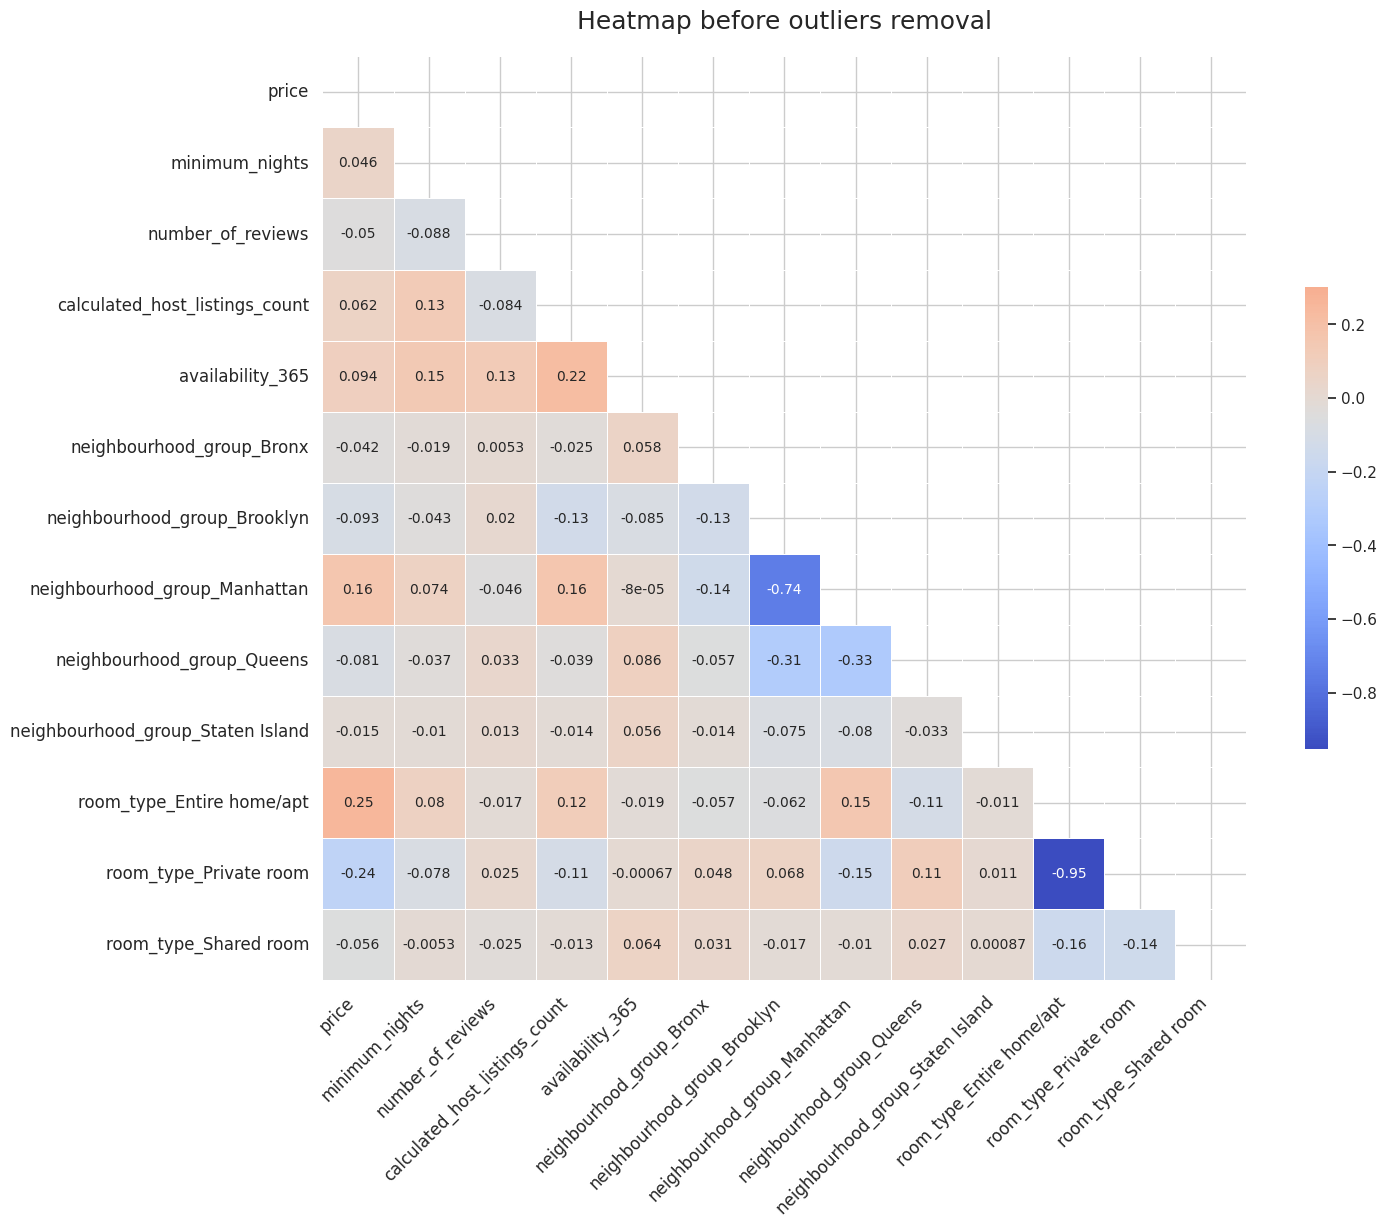

In [71]:
#for better plots visualization, we use some suggestions from Chat GPT
# CORRELATION HEATMAPS BEFORE OUTLIERS REMOVAL

numcorr = df_nyc_corr.select_dtypes(include=[np.number])
df_nyc_corr = numcorr.corr()

mask = np.triu(np.ones_like(df_nyc_corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 12))
cmap = sns.diverging_palette(200, 10, as_cmap=True)
sns.heatmap(
    df_nyc_corr,
    cmap="coolwarm",
    mask=mask,
    vmax=0.3,
    center=-0.05,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    annot_kws={"size": 10})


plt.title("Heatmap before outliers removal", fontsize=18, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

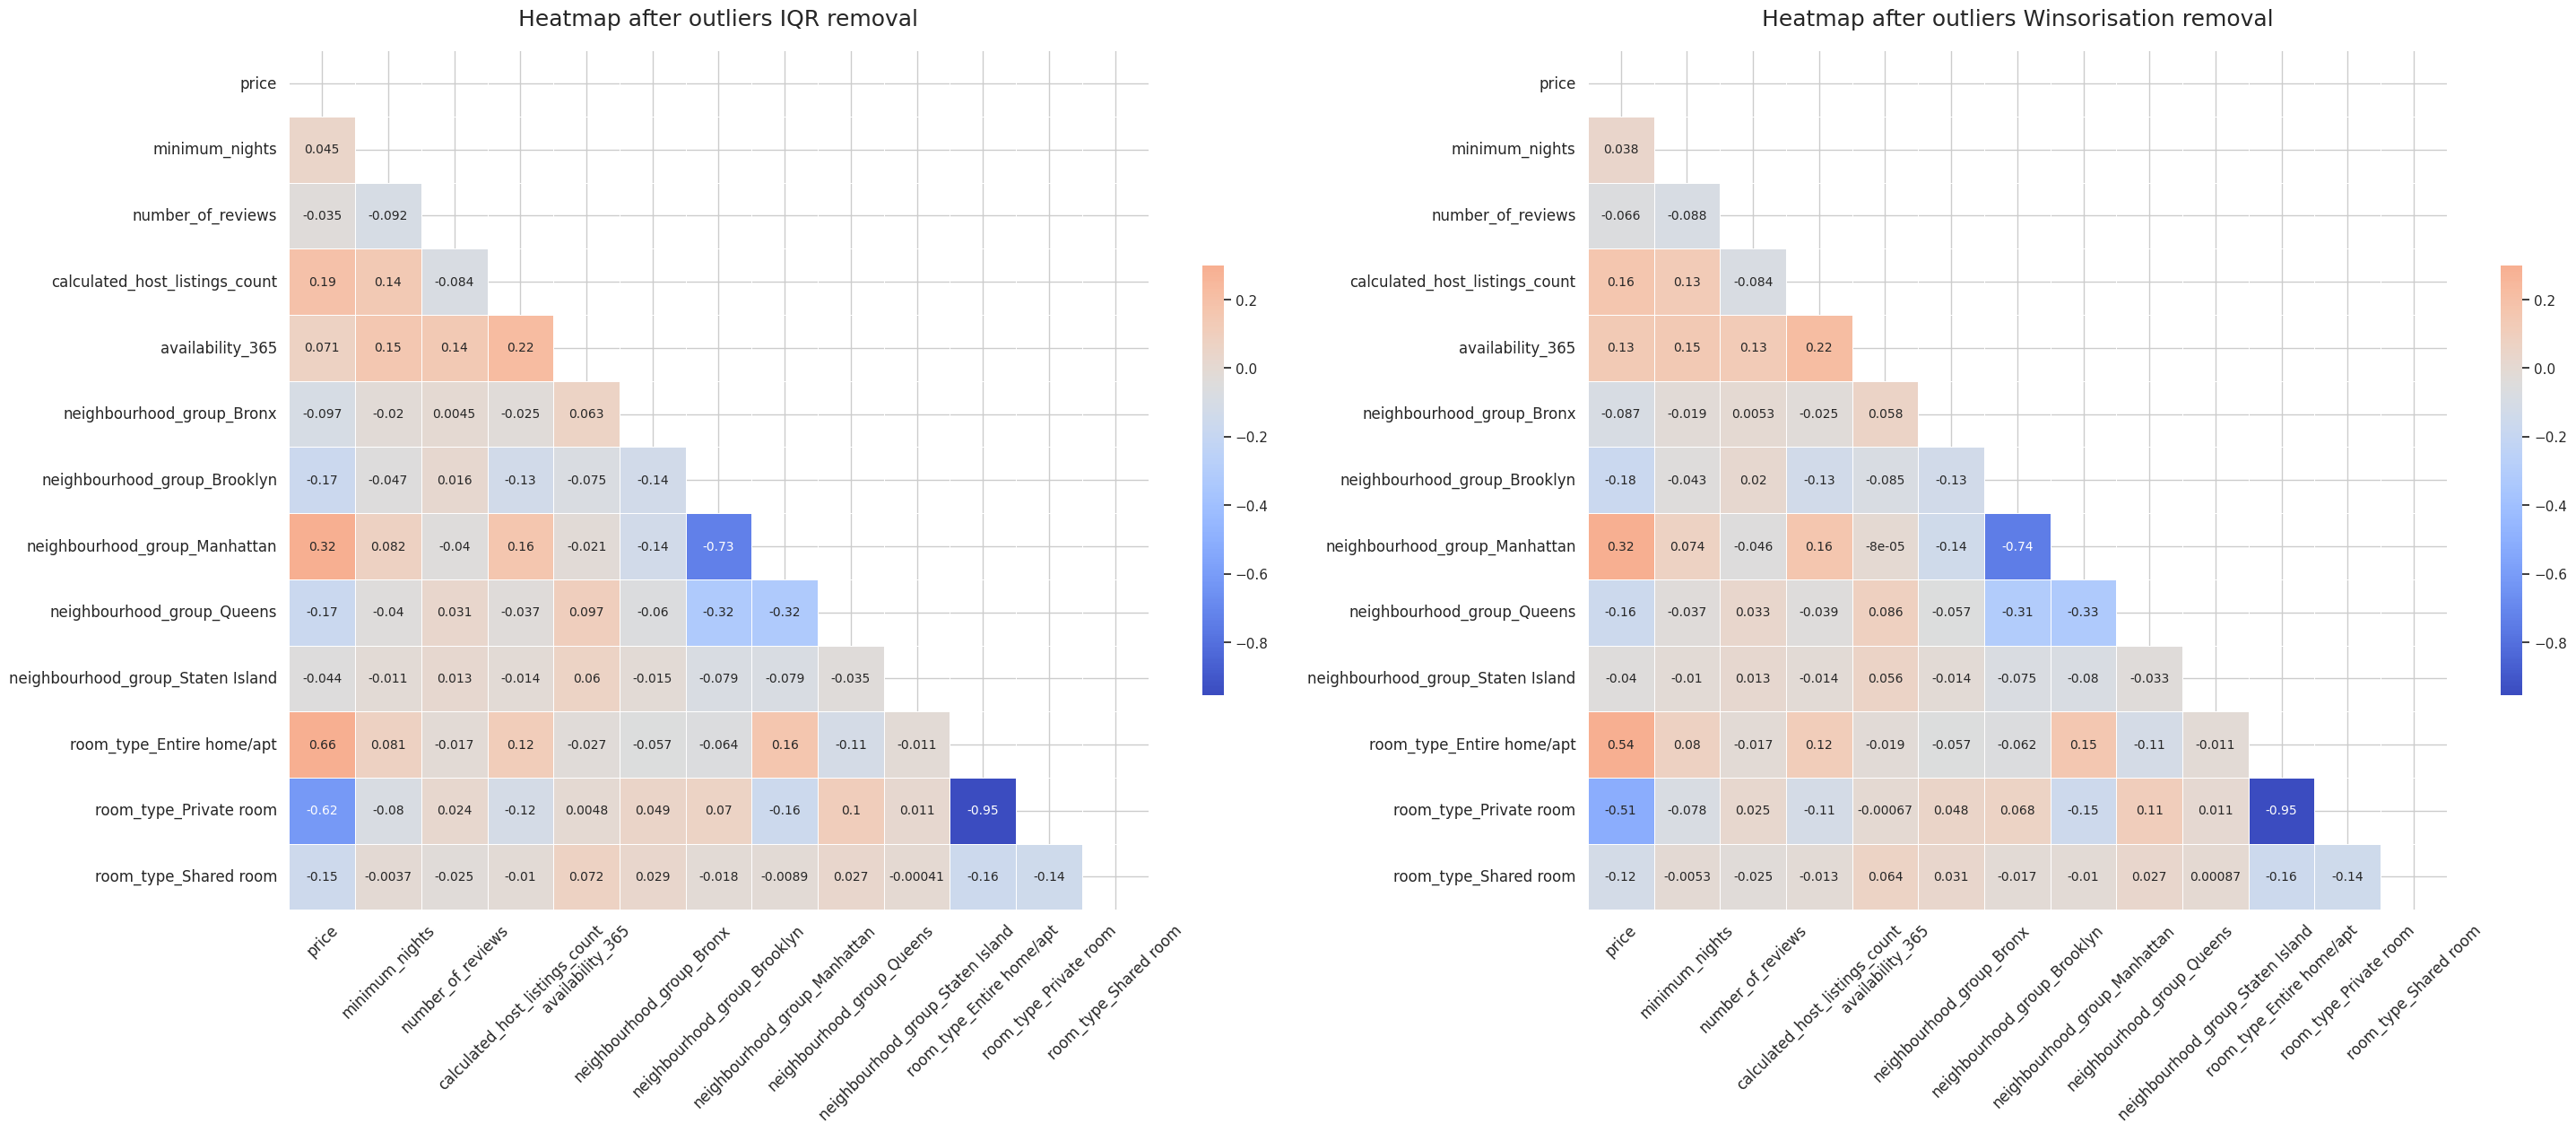

In [72]:
# CORRELATION HEATMAPS AFTER OUTLIERS REMOVAL

numIQR = df_nyc_IQR.select_dtypes(include=[np.number])
numwins = df_nyc_winsor.select_dtypes(include=[np.number])

df_nyc_corrIQR = numIQR.corr()
df_nyc_corrwins = numwins.corr()

fig, axes = plt.subplots(1, 2, figsize=(30, 12))


# IQR treated data
mask_iqr = np.triu(np.ones_like(df_nyc_corrIQR, dtype=bool))
sns.heatmap(
    df_nyc_corrIQR,
    mask=mask_iqr,
    cmap="coolwarm",
    vmax=0.3,
    center=-0.05,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    annot_kws={"size": 10},
    ax=axes[0])
axes[0].set_title("Heatmap after outliers IQR removal", fontsize=18, pad=20)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)


# Winsorised treated data
mask_winsor = np.triu(np.ones_like(df_nyc_corrwins, dtype=bool))
sns.heatmap(
    df_nyc_corrwins,
    mask=mask_winsor,
    cmap="coolwarm",
    vmax=0.3,
    center=-0.05,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    annot_kws={"size": 10},
    ax=axes[1])
axes[1].set_title("Heatmap after outliers Winsorisation removal", fontsize=18, pad=20)
axes[1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

After the outliers were removed, the correlation between some variables increased, especially the correlation of price vs room type (Private room), from -0.24 to -0.62 and -0.51. However, they are still in an average range which can be used for further machine learning.

From the correlation matrix, the Winsorisation outliers removal method provides a slightly better result.

Final Check data condition of outliers removal with IQR treatment and Winsorisation

In [73]:
df_nyc_IQR.head(3)

price  minimum_nights  number_of_reviews  \
0  0.370667        0.000000           0.014308   
1  0.573333        0.000000           0.071542   
2  0.373333        0.001601           0.000000   

   calculated_host_listings_count  availability_365  \
0                        0.015337          1.000000   
1                        0.003067          0.972603   
2                        0.000000          1.000000   

   neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                          0                             1   
1                          0                             0   
2                          0                             0   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                              0                           0   
1                              1                           0   
2                              1                           0   

   neighbourhood_group_Staten Island  room_type_Entire home/apt  \
0                                  0                          0   
1                                  0                          1   
2                                  0                          0   

   room_type_Private room  room_type_Shared room  
0                       1                      0  
1                       0                      0  
2                       1                      0

In [74]:
df_nyc_winsor.head(3)

price  minimum_nights  number_of_reviews  \
0  0.315909        0.000000           0.014308   
1  0.488636        0.000000           0.071542   
2  0.318182        0.001601           0.000000   

   calculated_host_listings_count  availability_365  \
0                        0.015337          1.000000   
1                        0.003067          0.972603   
2                        0.000000          1.000000   

   neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                          0                             1   
1                          0                             0   
2                          0                             0   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                              0                           0   
1                              1                           0   
2                              1                           0   

   neighbourhood_group_Staten Island  room_type_Entire home/apt  \
0                                  0                          0   
1                                  0                          1   
2                                  0                          0   

   room_type_Private room  room_type_Shared room  
0                       1                      0  
1                       0                      0  
2                       1                      0